# Import

In [236]:
import pickle
from tqdm import tqdm

import numpy as np
import pandas as pd
import xlwings as xw
import FinanceDataReader as fdr

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

from sklearn.preprocessing import MinMaxScaler

from utils import *

# Data

- 구성할 유니버스

In [161]:
stocks = ['삼성전자', 'NAVER','LG화학','삼성바이오로직스','CJ제일제당', 'HMM']
stock_vars = ['se','naver','lg','sb', 'cj', 'hmm']

- xlsx파일에서 해당 종목들의 데이터를 가져오기

In [162]:
for stock, var in zip(stocks, stock_vars):
    globals()[var] = get_data(stock)

- 현금은 KOSEF 단기자금으로

In [163]:
# kosef 단기자금
cash = fdr.DataReader('130730')[['Close']]
cash = cash.rename(columns={'Close':'cash_Close'})
kospi = fdr.DataReader('KS11')[['Close']]
kospi.columns = ['kospi_Close']

- 모두 합치기

In [177]:
data = pd.concat([se, naver, lg, sb, cj, hmm], axis=1)
data.index = pd.to_datetime(data.index)
data = data.dropna()
data = pd.concat([kospi, cash, data], axis=1).dropna()
data = data.reset_index()

- Feature Engineering: 근 한달 간의 Std 평균

In [239]:
stocks_close = [s + '_Close' for s in stocks]
tmp = data[stocks_close]
std_avg_p1m = calc_average_std(tmp)

- Target Data (Future Volatility) 만들기

In [181]:
std_avg_p1m = [np.nan]*20 + std_avg_p1m
data.loc[:, 'STD_avg_p1m'] = std_avg_p1m
data = data.dropna()
data['STD_yearly_f1m'] = data['STD_avg_p1m'].shift(-21) * np.sqrt(252)
data = data.dropna()
df = data.copy().reset_index()

# 학습/평가 기간 정의

In [230]:
train_dates = [('2017-04', '2017-09-30'), ('2017-05', '2017-10-31'), ('2017-06', '2017-11-30'), 
               ('2017-07', '2017-12-31'), ('2017-08', '2018-01-31'),('2017-09', '2018-02-28'), 
               ('2017-10','2018-03-31'), ('2017-11', '2018-04-30'),('2017-12', '2018-05-31'), 
               ('2018-01','2018-06-30'), ('2018-02', '2018-07-31'),('2018-03', '2018-08-31'), 
               ('2018-04', '2018-09-30'), ('2018-05', '2018-10-31'), ('2018-06', '2018-11-30'),
               ('2018-07','2018-12-31'), ('2018-08', '2019-01-31'), ('2018-09', '2019-02-28'), 
               ('2018-10', '2019-03-31'),('2018-11', '2019-04-30'), ('2018-12', '2019-05-31'), 
               ('2019-01','2019-06-30'), ('2019-02', '2019-07-31'),('2019-03', '2019-08-31'), 
               ('2019-04', '2019-09-30'), ('2019-05','2019-10-31'), ('2019-06', '2019-11-30'),
               ('2019-07', '2019-12-31'), ('2019-08', '2020-01-31'), ('2019-09','2020-02-29'), 
               ('2019-10', '2020-03-31'),('2019-11', '2020-04-30'), ('2019-12', '2020-05-31'), 
               ('2020-01','2020-06-30'), ('2020-02', '2020-07-31'),('2020-03', '2020-08-31'), 
               ('2020-04', '2020-09-30'), ('2020-05','2020-10-31'), ('2020-06', '2020-11-30'),
               ('2020-07', '2020-12-31'), ('2020-08', '2021-01-31'), ('2020-09','2021-02-28'), 
               ('2020-10', '2021-03-31'),('2020-11', '2021-04-30'), ('2020-12', '2021-05-31'), 
               ('2021-01','2021-06-30'), ('2021-02', '2021-07-31'),('2021-03', '2021-08-31'),
               ('2021-04', '2021-09-30')]
predict_dates = [(tup[1][:7], tup[1])
                 for tup in train_dates][1:] + [('2021-10', '2021-10-31')]

# 학습

In [54]:
monthly_weights = []
for tr, pr in tqdm(list(zip(train_dates, predict_dates))):
    train_duration = [tr[0], tr[1]]
    test_duration = [pr[0], pr[1]]

    train_mask = (df.Date >= train_duration[0]) & (
        df.Date <= train_duration[1])
    train_data = df.loc[train_mask]

    test_mask = (df['Date'] >= test_duration[0]) & (
        df['Date'] <= test_duration[1])
    test_data = df.loc[test_mask]

    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)

    tickers = ['kospi_Close', 'cash_Close'] + [x + '_Close' for x in stocks]

    for idx, ticker in enumerate(tickers):
        train_data[ticker + str('_N')] = train_data[ticker] / \
            train_data[ticker][0]

    volatility = []
    expected_returns = []

    for ticker in tickers:
        returns = np.log(
            train_data[ticker + str('_N')] / train_data[ticker + str('_N')].shift(1))
        returns = returns.dropna()

        if ticker == 'cash_Close':
            volatility.append(0)
        else:
            volatility.append(np.sqrt(returns.var()*252))
        expected_returns.append(returns.mean()*252)

    universe = train_data.columns.tolist()[-len(stocks)-1:]

    sampled_data = weight_sampling(universe, 200000)
    weights_data = portfolio_table(sampled_data)

    y_train = train_data['STD_yearly_f1m']
    x_train = train_data.drop(['Date', 'STD_yearly_f1m'], axis=1)
    x_train = x_train.drop([x for x in x_train.columns if '_N' in x], axis=1)

    y_test = test_data['STD_yearly_f1m']
    x_test = test_data.drop(['Date', 'STD_yearly_f1m'], axis=1)

    scaler = MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)

    # Elastic Net
    en_clf = elasticnet_model()
    en_clf.fit(x_train_scaled, y_train)
    y_test_pred_en = en_clf.predict(x_test_scaled)

    # Random Forest
    rf_clf = randomforest_model()
    rf_clf.fit(x_train_scaled, y_train)
    y_test_pred_rf = rf_clf.predict(x_test_scaled)

    # XGBoost
    xgb_clf = xgboost_model()
    xgb_clf.fit(x_train_scaled, y_train)
    y_test_pred_xgb = xgb_clf.predict(x_test_scaled)

    # Support Vector Machine
    svr_clf = svr_model()
    svr_clf.fit(x_train_scaled, y_train)
    y_test_pred_svr = svr_clf.predict(x_test_scaled)

    # Voting ensemble
    y_test_array = np.stack(
        (y_test_pred_en, y_test_pred_rf, y_test_pred_xgb, y_test_pred_svr))
    y_test_pred_ensemble = np.average(y_test_array, axis=0)
    pred_target = y_test_pred_ensemble[0].round(2)

    if (pred_target <= weights_data['volatility_round'].max()) & (pred_target >= weights_data['volatility_round'].min()):
        idx = np.argmin(((weights_data['volatility'] - pred_target) ** 2))
        final_weights = weights_data.iloc[[idx]]

    elif pred_target > weights_data['volatility_round'].max():
        final_weights = weights_data[weights_data['volatility_round']
                                     == weights_data['volatility_round'].max()]
    else:
        final_weights = weights_data[weights_data['volatility_round']
                                     == weights_data['volatility_round'].min()]

    company_name = []
    company_weights = []
    for i in list(final_weights)[0:len(stocks)+1]:
        company_name.append(i[:-2])
        company_weights.append(float(final_weights[i].values))
    monthly_weights.append(list(zip(company_name, company_weights)))

    money = 10000000

    stock_prices = test_data.loc[0][company_name]
    stock_shares = []

    for i in range(len(company_weights)):
        stock_shares.append(money * company_weights[i] / stock_prices[i])

    investment = np.zeros(len(test_data))

    for i in range(len(company_name)):
        investment += test_data[company_name[i]] * stock_shares[i]

    test_data['investment_asset'] = investment

    test_data['KOSPI_ref'] = test_data['kospi_Close'] / \
        test_data.loc[0]['kospi_Close']
    test_data['Strategy'] = test_data['investment_asset'] / \
        test_data.loc[0]['investment_asset']

    test_data.to_csv(f'testdata/{pr[0]}.csv')
    with open(f'monthly_weights/{pr[0]}.pkl', 'wb') as f:
        pickle.dump(monthly_weights, f)

100%|██████████| 49/49 [12:01:58<00:00, 884.05s/it]   


## 마코위츠 MVO를 통한 비교군 형성

In [ ]:
for tr, pr in tqdm(list(zip(train_dates, predict_dates))):
    train_duration = [tr[0], tr[1]]
    test_duration = [pr[0], pr[1]]

    train_mask = (df.Date >= train_duration[0]) & (
        df.Date <= train_duration[1])
    train_data = df.loc[train_mask]

    test_mask = (df['Date'] >= test_duration[0]) & (
        df['Date'] <= test_duration[1])
    test_data = df.loc[test_mask]

    train_data = train_data.reset_index(drop=True)
    test_data = test_data.reset_index(drop=True)

    tickers = ['kospi_Close', 'cash_Close'] + [x + '_Close' for x in stocks]

    mu = mean_historical_return(train_data[tickers[1:]])
    S = risk_matrix(train_data[tickers[1:]])

    ef = EfficientFrontier(mu, S)

    weights = ef.max_sharpe(risk_free_rate=0.01)
    cleaned_weights = dict(ef.clean_weights())

    money = 10000000

    stock_prices = test_data.loc[0][list(dict(cleaned_weights).keys())]
    stock_shares = []

    for i in range(len(dict(cleaned_weights))):
        stock_shares.append(
            money * list(dict(cleaned_weights).values())[i] / stock_prices[i])

    investment = np.zeros(len(test_data))

    for i in range(len(dict(cleaned_weights))):
        investment += test_data[list(dict(cleaned_weights).keys())
                                [i]] * stock_shares[i]

    test_data['investment_asset'] = investment

    test_data['KOSPI_ref'] = test_data['kospi_Close'] / \
        test_data.loc[0]['kospi_Close']
    test_data['Markowitz'] = test_data['investment_asset'] / \
        test_data.loc[0]['investment_asset']

    test_data.to_csv(f'markowitz_testdata/{pr[0]}.csv')

# 결과 비교

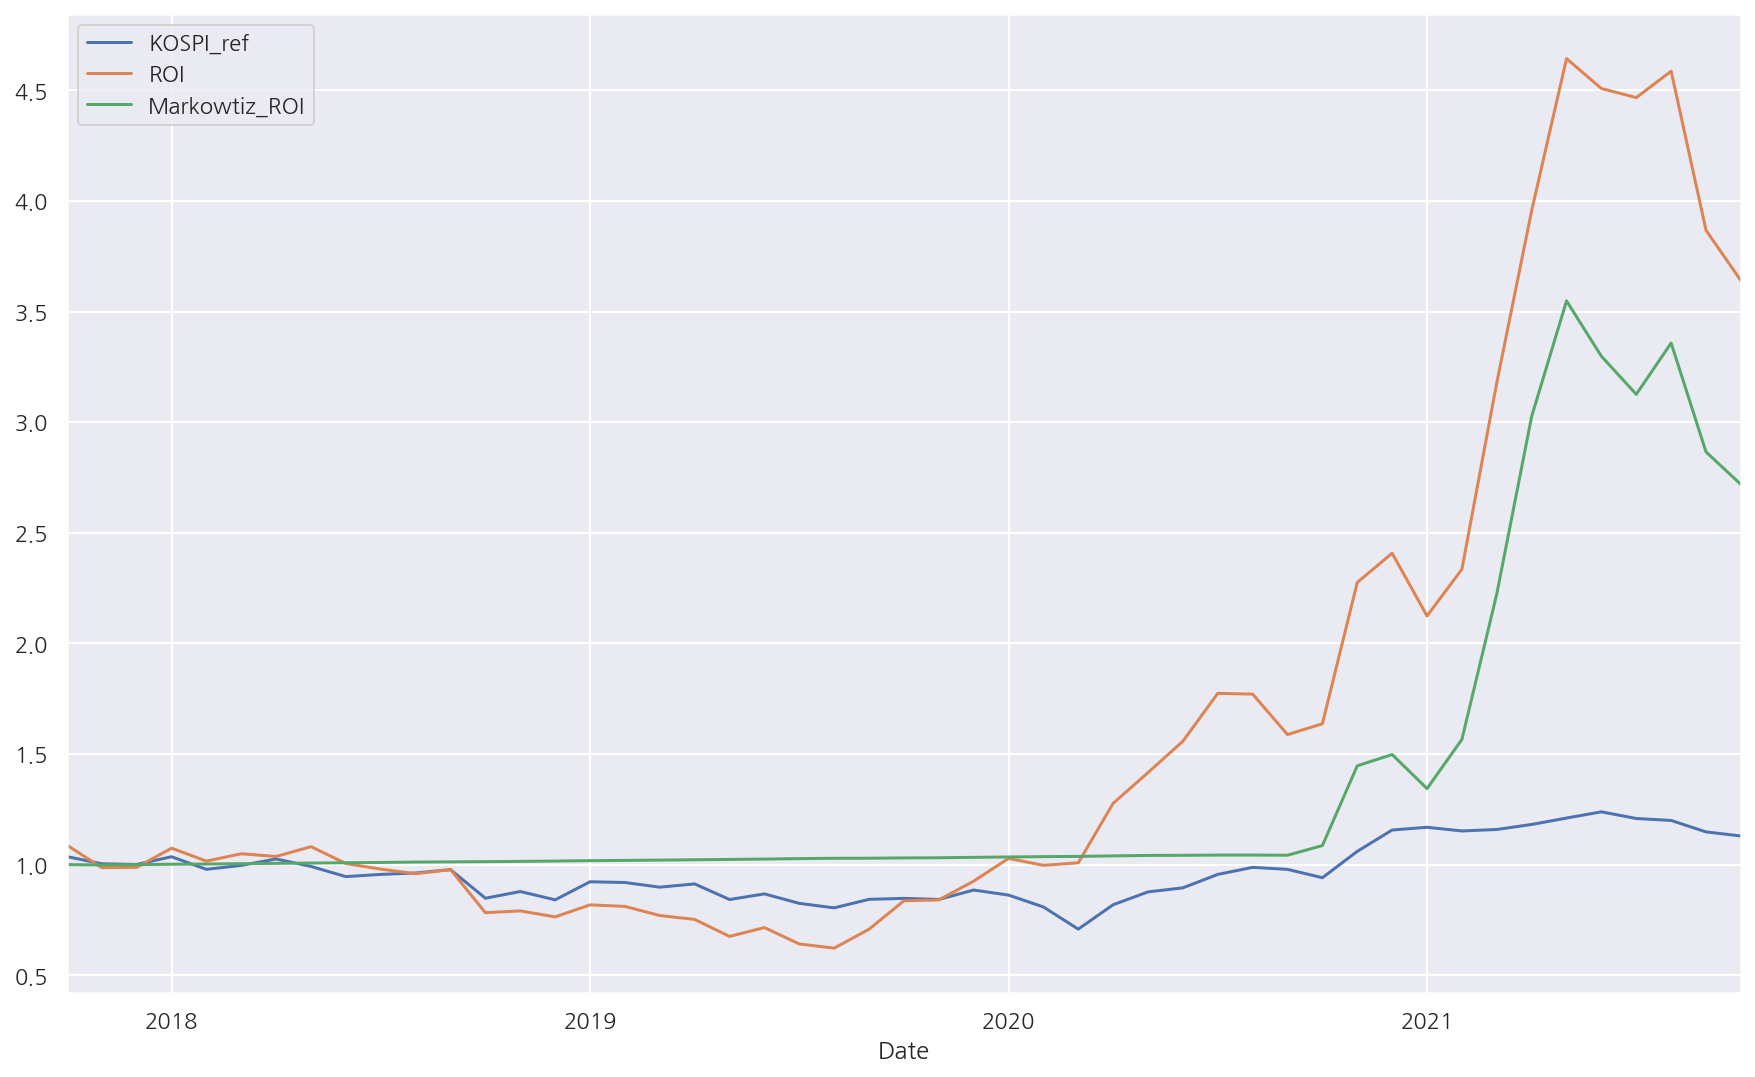

In [231]:
total = pd.DataFrame()
for tup in predict_dates:
    td = pd.read_csv(f'testdata/{tup[0]}.csv')[['Date', 'KOSPI_ref', 'Strategy']]
    md = pd.read_csv(f'markowitz_testdata/{tup[0]}.csv')[['Date', 'KOSPI_ref', 'Markowitz']]
    td['Markowtiz'] = md['Markowitz']
    total = pd.concat([total, td], axis=0)
    
total.Date = pd.to_datetime(total.Date)
total = total.set_index('Date') 
total.resample('M').last().cumprod().plot(figsize=(15,9))
plt.show()